In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy import linalg
import scipy.integrate as integrate
from scipy.special import gamma
import time

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from sklearn.utils import check_random_state
from sklearn import cluster
from sklearn.model_selection import KFold

import pandas as pd
from astropy.stats import sigma_clip

In [2]:
class my_GMM(GMM):
    """
    Custom GMM class based on the sklearn GMM class.
    This allows to work with a GMM with fixed parameters, without fitting it.
    It also allows to estimate MI with a certain number of MC samples.
    The different initialisation types are dealt with separately.
    """
    def __init__(self,
                 n_components=1,
                 covariance_type="full",
                 tol=1e-5,
                 reg_covar=1e-6,
                 max_iter=100,
                 n_init=1,
                 init_params="random",
                 random_state=None,
                 warm_start=False,
                 verbose=0,
                 verbose_interval=10,
                 weights_init=None,
                 means_init=None,
                 precisions_init=None,
                 covariances_init=None
                 ):
        super(my_GMM, self).__init__(n_components=n_components,
                 covariance_type=covariance_type,
                 tol=tol,
                 reg_covar=reg_covar,
                 max_iter=max_iter,
                 n_init=n_init,
                 init_params=init_params,
                 random_state=random_state,
                 warm_start=warm_start,
                 verbose=verbose,
                 verbose_interval=verbose_interval,
                 weights_init=weights_init,
                 means_init=means_init,
                 precisions_init=precisions_init,
                )

        self.means_ = means_init
        self.covariances_ = covariances_init
        self.covariances_init = covariances_init
        self.weights_ = weights_init
        #self.random_state = random_state
        #self.covariance_type = covariance_type
        #self.precisions_cholesky_ = _compute_precision_cholesky(
        #        self.covariances_, self.covariance_type
        #    )


    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def predict(self, X):
        """Predict the labels for the data samples in X using trained model.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba(self, X):
        """Evaluate the components' density for each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Density of each Gaussian component for each sample in X.
        """
        # copied here to remove the fitting check
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.
        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.
        y : array, shape (nsamples,)
            Component labels.
        """
        # copied here to remove the fitting check
        # check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components)
            )

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, covariance, int(sample))
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )
        elif self.covariance_type == "tied":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, self.covariances_, int(sample))
                    for (mean, sample) in zip(self.means_, n_samples_comp)
                ]
            )
        else:
            X = np.vstack(
                [
                    mean + rng.randn(sample, n_features) * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

    def score_samples_marginal(self, X, index=0):
        """Compute the log-likelihood of each sample for the marginal model, indexed by either 0 (x) or 1 (y).
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        index: integer
            Either 0 (marginal x) or 1 (marginal y).
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """

        oned_cholesky = np.sqrt(1/self.covariances_[:, index, index]).reshape(-1, 1, 1)
        marginal_logprob = _estimate_log_gaussian_prob(
            X, self.means_[:, index].reshape(-1, 1), oned_cholesky, self.covariance_type
        )

        return logsumexp(np.log(self.weights_) + marginal_logprob, axis=1)


    def estimate_MI_MC(self, MC_samples=100):
        """
        Compute the mutual information (MI) associated with a particular GMM model, using MC integration
        Parameters
        ----------
        MC_samples : integer
            Number of Monte Carlo samples to perform numerical integration of the MI integral.
        Returns
        ----------
        MI : integer
            The value of mutual information.
        -------
        """
        # sample MC samples
        points, clusters = self.sample(MC_samples)
        
        # we first evaluate the log-likelihood for the joint probability
        joint = self.score_samples(points)

        # we then evaluate the marginals; index=0 corresponds to x, index=y corresponds to y
        marginal_x = self.score_samples_marginal(points[:, :1], index=0)
        marginal_y = self.score_samples_marginal(points[:, 1:], index=1)

        MI = np.mean(joint - marginal_x - marginal_y)
        return MI
    
    def fit_predict(self, X, y=None):
        """Estimate model parameters using X and predict the labels for X.
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.
        .. versionadded:: 0.20
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        X = self._validate_data(X, dtype=[np.float64, np.float32], ensure_min_samples=2)
        if X.shape[0] < self.n_components:
            raise ValueError(
                "Expected n_samples >= n_components "
                f"but got n_components = {self.n_components}, "
                f"n_samples = {X.shape[0]}"
            )
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not (self.warm_start and hasattr(self, "converged_"))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.inf
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)

            lower_bound = -np.inf if do_init else self.lower_bound_

            for n_iter in range(1, self.max_iter + 1):
                #if n_iter==179:
                #    try:
                #        #print(n_iter)
                #        print(np.linalg.eig(self.covariances_[2]))
                #        #print(self.means_[2])
                #        #ind = np.argsort(log_resp[:, 2])[-5:]
                #        #print(X[ind])
                #        #print(log_resp[np.argmax(log_resp[:, 2])])
                #        #plt.hist(log_resp[:, 4])
                #    except:
                #        pass

                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                lower_bound = self._compute_lower_bound(log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn(
                "Initialization %d did not converge. "
                "Try different init parameters, "
                "or increase max_iter, tol "
                "or check for degenerate data." % (init + 1),
                ConvergenceWarning,
            )

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)
        


In [3]:
# now we also focus on initialising the GMM parameters
# we provide four different initialisation types, which return weights, means and covs
# these will go as input into the GMM class, so that we can ignore whatever happens there

  
def initialize_parameters(X, random_state, n_components=1, s=None, reg_covar=1e-6, init_type='random'):
    """Initialize the model parameters.
    Parameters
    ----------
    X : array-like of shape  (n_samples, n_features)
    random_state : RandomState
        A random number generator instance that controls the random seed used for the method chosen to initialize the parameters.
    n_components: int
        Number of components of the GMM to fit.
    s : float
        If set, sets component variances in the 'random' and 'minmax' cases. 
        If s is not given, it will be set such that the volume of all components
        completely fills the space covered by data.
    init_type : {'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'}, default='random'
        The method used to initialize the weights, the means and the
        precisions.
        Must be one of:
            'random': weights are set uniformly, covariances are proprtional to identity (with prefactor s^2). 
            For each mean, a data sample is selected at random, and a multivariant Gaussian with variance s^2 offset is added.
            'minmax': same as above, but means are distributed randomly over the range that is covered by data.
            'kmeans': k-means clustering run as in Algorithm 1 from Bloemer & Bujna (arXiv:1312.5946), as implemented by Melchior & Goulding (arXiv:1611.05806)
             WARNING: The result of this call are not deterministic even if rng is set because scipy.cluster.vq.kmeans2 uses its own initialization. 
             TO DO: require scipy > 1.7, and include "seed=random_state" in the kmeans call
            'kmeans_sklearn' : responsibilities are initialized using kmeans.
            'random_sklearn' : responsibilities are initialized randomly.
    reg_covar : float
        The regularization added to the diagonal of the covariance matrices.
    Returns
    ----------
    weights : array, shape (n_components, 1)
        The initial weights of the GMM model.
    means : array, shape (n_components, n_features)
        The initial means of the GMM model.        
    covariances : array, shape (n_components, n_features, n_features)
        The initial covariance matrices of the GMM model.        
    """
    n_samples, n_dim = X.shape

    random_state = check_random_state(random_state)
    if s is None and (init_type=='random' or init_type=='minmax'):
        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        vol_data = np.prod(max_pos-min_pos)
        s = (vol_data / n_components * gamma(n_dim*0.5 + 1))**(1/n_dim) / np.sqrt(np.pi)
        print(f"Scale s set to s={s:.2f}...")

    if init_type == "random":

        weights = np.repeat(1/n_components, n_components)
        # initialize components around data points with uncertainty s
        refs = random_state.randint(0, n_samples, size=n_components)

        means = X[refs] + random_state.multivariate_normal(np.zeros(n_dim), s**2 * np.eye(n_dim), size=n_components)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == "minmax":

        weights = np.repeat(1/n_components, n_components)

        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        means = min_pos + (max_pos-min_pos)*random_state.rand(n_components, n_dim)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == 'kmeans':
        from scipy.cluster.vq import kmeans2
        center, label = kmeans2(X, n_components)
        weights = np.zeros(n_components)
        means = np.zeros((n_components, n_dim))
        covariances = np.zeros((n_components, n_dim, n_dim))

        for k in range(n_components):
            mask = (label == k)
            weights[k] = mask.sum() / len(X)
            means[k,:] = X[mask].mean(axis=0)
            d_m = X[mask] - means[k,:] 
            # funny way of saying: for each point i, do the outer product
            # of d_m with its transpose and sum over i
            covariances[k,:,:] = (d_m[:, :, None] * d_m[:, None, :]).sum(axis=0) / len(X)

    elif init_type == "random_sklearn":
        resp = random_state.rand(n_samples, n_components)
        resp /= resp.sum(axis=1)[:, np.newaxis]
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    elif init_type == "kmeans_sklearn":
        resp = np.zeros((n_samples, n_components))
        label = (
            cluster.KMeans(
                n_clusters=n_components, n_init=1, random_state=random_state
            )
            .fit(X)
            .labels_
        )
        resp[np.arange(n_samples), label] = 1
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    else:
        # TO DO: raise error instead of just priting it
        print("Error: initalisation type not specified or not known; it should be one of 'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'")
        
    precisions = np.empty_like(covariances)
    for i in range(n_components):
        precisions[i] = np.linalg.inv(covariances[i])
        
    return weights, means, covariances, precisions


In [4]:
def MI_procedure_diffconvergence(X, n_components=1, n_folds=5, n_inits=5, init_type='random', reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)
    train_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []
        training_scores = []
        
        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            train_score = fitted_gmm.score_samples(X_training).mean()

            #print(val_score)
            validation_scores.append(np.copy(val_score))
            training_scores.append(np.copy(train_score))


        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        train_scores_seeds[r] = np.mean(training_scores)

        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)
    best_val_score = np.max(val_scores_seeds)
    best_train_score = np.max(train_scores_seeds)
    
    return best_seed, best_val_score, best_train_score

### Let's look at MI 

In [5]:
codes_file = 'encoded_harps_unique_128d_e182_i1500000.npy'
codes = pd.DataFrame(np.load(codes_file))

labels = pd.read_csv('harps_metadata_and_labels.csv')

#--- If looking at the 'unique' subset, drop unnecessary rows
if "unique" in codes_file:
    labels.dropna(subset=['unique_subset'],inplace=True)

#--- and reindex the codes dataframe accordingly
codes.loc[:,'dp_id'] = labels['dp_id'].values
labels = labels.set_index('dp_id')
codes = codes.set_index('dp_id')

In [6]:
from sklearn.feature_selection import mutual_info_regression
significant_dimensions = [ 11,  19,  58,  85,  99, 124]
stellar_params = ['radvel','Teff','Mass','[M/H]','airmass','snr','vsini']
MIs = np.zeros([len(stellar_params), \
                    len(significant_dimensions)])
codes_sig = codes.iloc[:, significant_dimensions]
                
for li,stellar_param in enumerate(stellar_params):        
    label = labels.loc[:,stellar_param].values
    
    ind_mask = ~np.isnan(label)
    label_ = sigma_clip(label,sigma=5,masked=True)

    ind_mask = ind_mask & (~label_.mask)
    label_ = label_.data[ind_mask]      
    for i in range(0,codes_sig.shape[1]):                          
        codes_ = codes_sig.iloc[:,i].values
        codes_ = codes_[ind_mask]
        
        MIs[li,i] = mutual_info_regression(codes_.reshape(-1, 1),label_)

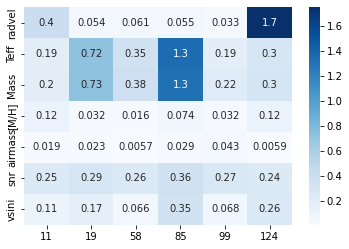

In [7]:
import seaborn as sns

plt.figure()
ax = sns.heatmap(MIs, annot=True, cmap='Blues')
ax.yaxis.set_ticklabels(stellar_params)
ax.xaxis.set_ticklabels(significant_dimensions)
plt.gcf().set_facecolor('white')

### Now use our approach

In [14]:
n_inits = 5
n_folds = 3
init_type = 'random_sklearn'
n_bootstrap = 100
MC_samples = 1e5
tol = 1e-5
reg_covar = 1e-13
components_range = 200
        
MI_all = np.zeros((len(stellar_params), 128, n_bootstrap))

for li,stellar_param in enumerate(stellar_params):
    if li <= 4:
        continue
    label = labels.loc[:,stellar_param].values
    
    ind_mask = ~np.isnan(label)
    label_ = sigma_clip(label,sigma=5,masked=True)

    ind_mask = ind_mask & (~label_.mask)
    samples1 = label_.data[ind_mask]    

    for latbin2 in range(128):
        codes_ = codes.iloc[:,latbin2].values
        samples2 = codes_[ind_mask]

        X = np.stack((samples1, samples2), axis=0).T

        # now we do this for many components, from 1 to 15

        all_MI_estimates = np.zeros((components_range, n_bootstrap))

        best_val = -np.inf

        initial_time = time.time()
        for n_components in range(1, components_range+1):
            current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                               init_type=init_type, n_inits=n_inits, tol=tol, reg_covar=reg_covar)

            # check if convergence has been reached based on val score
            if current_val > best_val:
                best_val = current_val
                best_seed = current_seed
                print(n_components, best_val)
            else:
                # if val score has not increased, then we should stop and calculate MI with the previous parameters
                best_components = n_components-1
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)

                    # in case of "warm start", uncomment next line
                    #w_init, m_init, c_init, p_init = gmm.weights_, gmm.means_, gmm.covariances_, gmm.precisions_

                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
                    MI_estimates[i] = current_MI_estimate
                break

        print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
        print()
        MI_all[li, latbin2] = MI_estimates
        print(li, latbin2, np.mean(MI_estimates), np.std(MI_estimates))
        print()

1 -2.830033652171688
2 -2.30295365251313
3 -2.1918650565665594
4 -1.3711452432416902
5 -1.3422908650310241
6 -1.306840815026267
7 -1.2923394952641474
8 -1.2838922934926427
9 -1.2751759961185785
10 -1.2735225086343223
11 -1.2713617996528352
12 -1.2677958577915922
13 -1.2640880102092764
14 -1.262579952538206
Convergence reached at 14 components
Total time to run the procedure: 603.34 s

5 0 0.28611428457823357 0.008842675198629926

1 -3.0050938312074993
2 -1.7501422812384781
3 -1.2191353646117762
4 -1.1512445847298707
5 -1.119509343080761
6 -1.0957267536495798
4 -0.9903516480152302
5 -0.9711641713449034
6 -0.9467952153226822
7 -0.932752435621978
8 -0.9304579666336537
9 -0.9271261691581175
Convergence reached at 9 components
Total time to run the procedure: 286.35 s

5 2 0.2762856716852529 0.0109285022438654

1 -2.0746092232424918
2 -1.8059327228370716
3 -1.5313773516518976
4 -1.0719914105488177
5 -1.0243508839208249
6 -1.0130833912211157
7 -1.009140174718842
8 -1.0072071479199929
9 -1.00

2 -2.3973050998627023
3 -1.6941840210619616
4 -1.3971497618338684
5 -1.3656601804866522
6 -1.321022698166621
7 -1.3105394915514215
8 -1.3033983008610515
9 -1.2909011826973504
Convergence reached at 9 components
Total time to run the procedure: 262.82 s

5 25 0.2374425133447278 0.008431613250291512

1 -2.657282228031122
2 -2.3689889656587484
3 -2.304531560571312
4 -1.5806351071687106
5 -1.5619488696555937
6 -1.5279821645384442
7 -1.5148914630054737
8 -1.5113097794152182
9 -1.5109946910781542
10 -1.502830068504374
Convergence reached at 10 components
Total time to run the procedure: 376.41 s

5 26 0.2521163000421408 0.008849372675891533

1 -2.647764766793717
2 -2.3195382247619243
3 -1.4891848340884462
4 -1.4254766043169014
5 -1.399281888377491
6 -1.360536282244192
7 -1.3547855923861851
8 -1.3456541689834918
9 -1.341953939194256
10 -1.336707484576892
Convergence reached at 10 components
Total time to run the procedure: 325.25 s

5 27 0.27928765626197316 0.00927998796781693

1 -2.262580939

2 -2.2778398227839145
3 -1.3165613886031158
4 -1.2507306186319171
5 -1.204608655979059
6 -1.1935642158462494
7 -1.190936392318395
8 -1.1888212502366091
9 -1.1846407933288134
10 -1.1794299376096815
Convergence reached at 10 components
Total time to run the procedure: 332.10 s

5 48 0.2451844071029608 0.007911954196614676

1 -2.5108119143064442
2 -2.1423356551284822
3 -1.756874899686838
4 -1.2427604399079806
5 -1.1920637247732253
6 -1.1876489860863717
7 -1.1821079135187995
8 -1.1795109380536282
Convergence reached at 8 components
Total time to run the procedure: 235.49 s

5 49 0.25445478899020296 0.008221508503498873

1 -3.0115303514020524
2 -2.4666202383924682
3 -2.104075807587497
4 -1.4824699103732353
5 -1.4259589214195867
6 -1.389767848036099
7 -1.3722849351297814
8 -1.362710300657052
9 -1.3624305355654123
Convergence reached at 9 components
Total time to run the procedure: 245.21 s

5 50 0.2867608526614873 0.00888011167078355

1 -2.1172102665488275
2 -1.8612421047876522
3 -1.80039468

2 -1.8787596738021535
3 -1.8065132605711087
4 -1.0593318761234187
5 -1.0469738867758698
6 -1.0426433909106072
7 -1.00314207244255
8 -0.9939694927908169
9 -0.9921353254928257
10 -0.988854247535841
Convergence reached at 10 components
Total time to run the procedure: 307.50 s

5 72 0.27599704729125774 0.008894252058462919

1 -2.5131723061159557
2 -2.1516611969685133
3 -2.084674444090061
4 -1.5739238002766036
5 -1.52857183218788
6 -1.4996627584560567
7 -1.2698097617299637
8 -1.264389643805824
9 -1.261056308743778
10 -1.258756976650391
Convergence reached at 10 components
Total time to run the procedure: 391.57 s

5 73 0.27943016394365094 0.009416073303347438

1 -2.711913658701247
2 -2.1861801970711707
3 -1.732215522329404
4 -1.6376331316972512
5 -1.0584301627156723
6 -1.0108646256872111
7 -0.9959224713142699
8 -0.9887541951238052
9 -0.9831918841956965
10 -0.9805270155996982
11 -0.9733989531626518
Convergence reached at 11 components
Total time to run the procedure: 302.12 s

5 74 0.267584

Total time to run the procedure: 518.88 s

5 95 0.28208167824390173 0.009318201508868333

1 -2.9787967659981702
2 -1.7770109736620752
3 -1.2366161223273224
4 -1.1764751415347432
5 -1.1416427433079956
6 -1.1376622550453108
7 -1.11889492600811
8 -1.1171075709157647
9 -1.1158225399658301
10 -1.110599548430854
11 -1.1090485510201282
12 -1.1086670096733335
Convergence reached at 12 components
Total time to run the procedure: 372.52 s

5 96 0.25054711547322844 0.00762379680300792

1 -2.315548933666704
2 -2.048191387180891
3 -1.981958183954715
4 -1.3206280606802914
5 -1.293463273875553
6 -1.257464881104021
7 -1.2494715991103753
8 -1.245817819284634
Convergence reached at 8 components
Total time to run the procedure: 263.65 s

5 97 0.22659685033928006 0.007879745961298227

1 -2.848002544479512
2 -2.4320335825344075
3 -1.5760433331371433
4 -1.5073831775570905
5 -1.4871122235028515
6 -1.458220788795769
7 -1.45013213524372
8 -1.4494610848513332
9 -1.4457893718548684
10 -1.440410207620749
11 -1.44

10 -1.4143299965706284
Convergence reached at 10 components
Total time to run the procedure: 310.46 s

5 119 0.25184278603949395 0.008413243404167098

1 -2.9631150949970415
2 -2.2131815061241675
3 -1.2568720472482406
4 -1.184229517626834
5 -1.1361517367119107
6 -1.1258839159179528
7 -1.1225393027486743
8 -1.115699401793454
9 -1.1133725457154167
10 -1.1122147402182867
Convergence reached at 10 components
Total time to run the procedure: 279.56 s

5 120 0.257716125504596 0.008821422900268014

1 -2.2951418580090697
2 -1.9842655547022925
3 -1.6701030277427371
4 -1.1353123221539716
5 -1.1164793209017727
6 -1.0734147152970832
7 -1.067235247137484
Convergence reached at 7 components
Total time to run the procedure: 169.84 s

5 121 0.2647199361152216 0.008655152611581148

1 -2.386861984575084
2 -2.0963279290663404
3 -2.012591792886848
4 -1.2839428675017812
5 -1.2481851824360144
6 -1.2320622981150198
7 -1.2163908503666025
8 -1.2100990763437254
Convergence reached at 8 components
Total time to r

2 -0.4056123575249237
3 -0.16769946899836527
4 -0.10782765243642274
5 -0.08217346750409903
6 -0.07580122224637509
Convergence reached at 6 components
Total time to run the procedure: 31.30 s

6 0 0.08128186794244191 0.017869301164081326

1 -1.0905923250565044
2 -0.19968653529661784
3 0.004420830307832767
4 0.08844442287273974
5 0.10238953358188901
6 0.12385670326646858
7 0.13432623416758227
Convergence reached at 7 components
Total time to run the procedure: 41.27 s

6 1 0.1174156655952314 0.027790295274442097

1 -0.9154728983985132
2 -0.02424857351445904
3 0.15674349100352525
4 0.18245292350813966
Convergence reached at 4 components
Total time to run the procedure: 19.70 s

6 2 0.07896012422731043 0.020556099513352532

1 -0.8943865509162466
2 -0.06524461831541803
3 0.14958724443403235
4 0.1665033278891198
Convergence reached at 4 components
Total time to run the procedure: 17.76 s

6 3 0.05291911243309981 0.023054107406288486

1 -0.7716547456487399
2 0.18464584031107342
3 0.3868409467

5 -0.005376133006187639
6 -0.0003715349795139396
7 0.019648763200469644
Convergence reached at 7 components
Total time to run the procedure: 43.69 s

6 34 0.10545764818470146 0.027752075437400405

1 -0.9264862374326466
2 -0.04035315384342653
3 0.17377585850393892
4 0.18813849602102253
5 0.1915748026949539
Convergence reached at 5 components
Total time to run the procedure: 27.32 s

6 35 0.08972806576291785 0.02200562497623797

1 -1.3224536409436116
2 -0.4533211304088643
3 -0.2369771314931167
4 -0.22654617849046355
5 -0.14975436633662462
6 -0.13436235683210127
Convergence reached at 6 components
Total time to run the procedure: 31.40 s

6 36 0.09014880707290035 0.033425365541594955

1 -0.6936463654568948
2 0.15293541200305172
3 0.3530521938118533
4 0.38175238489997093
Convergence reached at 4 components
Total time to run the procedure: 18.78 s

6 37 0.0747294701524621 0.01900036421857386

1 -1.2455626609524997
2 -0.3884396623134716
3 -0.20519224443416717
4 -0.14503082832341
5 -0.1359760

KeyboardInterrupt: 

In [18]:
np.save('./MI_all_5.npy', MI_all[5:6])

In [17]:
MI_all[5:6]

0.03158584283943094

In [30]:
MI1 = np.load('./MI_all_1.npy')
MI2 = np.load('./MI_all_2.npy')
MI3 = np.load('./MI_all_3.npy')
MI4 = np.load('./MI_all_4.npy')
MI5 = np.load('./MI_all_5.npy')
MI6 = np.load('./MI_all_6.npy')

In [32]:
MI1.shape, MI2.shape, MI3.shape, MI4.shape, MI5.shape, MI6.shape

((1, 128, 100),
 (1, 128, 100),
 (1, 128, 100),
 (2, 128, 100),
 (1, 128, 100),
 (1, 128, 100))

In [37]:
MI_all = np.concatenate((MI1, MI2, MI3, MI4, MI5, MI6), axis=0)

In [46]:
np.save('./MI_all.npy', MI_all)

### Plot MI

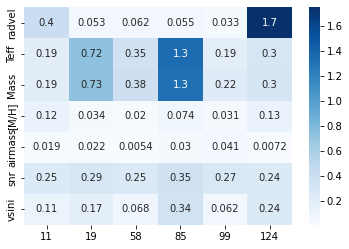

In [73]:
import seaborn as sns

plt.figure()
ax = sns.heatmap(MIs, annot=True, cmap='Blues')
ax.yaxis.set_ticklabels(stellar_params)
ax.xaxis.set_ticklabels(significant_dimensions)
plt.gcf().set_facecolor('white')

In [75]:
indices_to_keep = [11, 19, 58, 85, 99, 124]
MI_all = np.load('./MI_all.npy')

MI_values = np.mean(MI_all, axis=-1)[:, indices_to_keep]

In [140]:
np.std(MI_all, axis=-1)[:, indices_to_keep]

array([[0.0197024 , 0.00548337, 0.00596116, 0.00433399, 0.01442787,
        0.04609233],
       [0.00991992, 0.01905691, 0.01437845, 0.01950495, 0.01426911,
        0.01011645],
       [0.01232458, 0.01625843, 0.01392622, 0.0197031 , 0.01320754,
        0.00949852],
       [0.01098752, 0.00678059, 0.00922002, 0.00643049, 0.01437109,
        0.00933507],
       [0.0046163 , 0.00406807, 0.00330522, 0.00499565, 0.00729576,
        0.00611699],
       [0.00637878, 0.00845733, 0.00844254, 0.00972384, 0.01009342,
        0.00867734],
       [0.04365209, 0.03371045, 0.03107115, 0.03109182, 0.02586843,
        0.02943022]])

In [77]:
MI_values.shape

(7, 6)

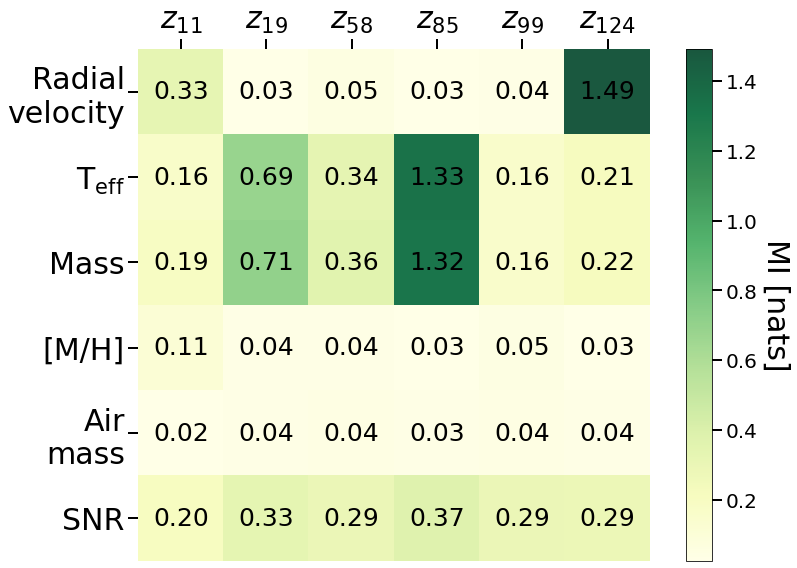

In [141]:
# plot

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.tick_params(labelsize=20, length=10, width=2) 
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=30)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(labels=col_labels, fontsize=30)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(labels=row_labels, fontsize=30)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, length=10, width=2)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #         rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, gmm_mi_std=None, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
        

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            #if data[i, j] == 0:
            #    continue
            #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

stellar_params_ = ['Radial\nvelocity','T$_{\mathregular{eff}}$','Mass','[M/H]','Air\nmass','SNR']#,'vsini']
vegetables = stellar_params_
farmers = [f"$z_{{{i}}}$" for i in indices_to_keep]#[f"$z_{i+$" for i in range(6)]

harvest = MI_values[:-1]


fig, ax = plt.subplots(1, 1, figsize=(12, 8))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)

fig.tight_layout()

In [106]:
#-------------------------------------------------------
# Load pre-computed codes, obtained by forward-passing 
# every HARPS spectrum half-way through a pre-trained 
# model (each 'encoded' file represents a distinct 
# pre-trained model).
#-------------------------------------------------------
codes_file = 'encoded_harps_unique_128d_e182_i1500000.npy'
codes = pd.DataFrame(np.load(codes_file))

nDimensions = codes.shape[1]

In [107]:
(codes.values).shape

(7007, 128)

In [108]:
#--- Compute MADS measures for all latent dimensions
measure = 'median' #or 'mean'
mads_threshold = 0.02
if measure == 'median':
    mads = mad(codes.values) # Median Absolute Deviation
else:
    mads = codes.mad().values # Mean Absolute Deviation

#--- Locate informative/significant dimensions
significant_dimensions = np.nonzero(mads > mads_threshold )[0]
print('Informative dimensions:',significant_dimensions)

#--- Visualize
plt.figure()
plt.scatter(mads, mads)
plt.stem(mads,use_line_collection=True)
plt.xlabel('node index')
plt.ylabel('M.A.D')
plt.ylim([0,1])
plt.title(codes_file.split('harps_encoded')[-1])
plt.show();

NameError: name 'mad' is not defined

In [109]:
#-------------------------------------------------------
# Load validation labels retrieved from the literature
#-------------------------------------------------------
labels = pd.read_csv('harps_metadata_and_labels.csv')

#--- If looking at the 'unique' subset, drop unnecessary rows
if "unique" in codes_file:
    labels.dropna(subset=['unique_subset'],inplace=True)

#--- and reindex the codes dataframe accordingly
codes.loc[:,'dp_id'] = labels['dp_id'].values
labels = labels.set_index('dp_id')
codes = codes.set_index('dp_id')
codes

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
dp_id,,,,,,,,,,,,,,,,,,,,,
ADP.2014-09-16T11:03:31.127,0.022619,0.008702,0.003565,-0.008090,-0.002158,0.019289,-0.004793,0.037820,0.009074,0.026378,...,0.011210,-0.024722,0.002371,-0.005110,-0.005057,0.001208,-0.156356,-0.005476,0.017024,-0.000261
ADP.2014-09-16T11:03:31.413,-0.003802,0.005300,-0.008371,-0.012530,-0.005186,0.005770,-0.006719,0.013567,0.002433,0.011316,...,0.002964,-0.014461,0.004969,0.011147,0.001793,0.013759,0.932076,-0.008795,-0.001797,-0.011051
ADP.2014-09-16T11:03:31.673,0.004768,0.012143,-0.004722,-0.004398,-0.002604,-0.002921,-0.006333,0.012474,0.010418,0.010521,...,0.003824,-0.022679,-0.003908,0.001823,0.007167,0.016491,0.070173,-0.003096,-0.000522,0.004261
ADP.2014-09-16T11:03:31.947,-0.004684,0.005786,-0.003726,-0.019478,-0.003583,-0.001197,-0.011058,0.004590,0.003639,-0.004696,...,0.000642,-0.008020,0.003465,0.013886,0.006208,0.022561,1.720115,-0.012932,-0.007507,0.003531
ADP.2014-09-16T11:03:32.443,-0.001797,0.002244,-0.007839,0.000821,-0.000663,0.009719,-0.000173,0.018266,0.008296,0.017897,...,0.017006,-0.025215,0.001325,-0.000884,0.000295,0.012396,0.465244,-0.007799,0.009903,-0.006600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADP.2018-07-26T01:02:10.221,0.040797,0.064959,-0.012087,0.001861,0.005347,-0.034136,-0.004237,0.060578,-0.039558,0.055059,...,0.002003,-0.048706,-0.054809,-0.013634,-0.008700,-0.010069,-0.008975,0.031549,0.024074,0.031486
ADP.2018-07-26T01:02:10.227,-0.010880,0.015008,-0.009106,-0.007652,0.002830,-0.001061,-0.006058,0.012178,-0.013519,0.019581,...,-0.013284,-0.019667,-0.000721,0.009685,0.000454,0.026580,0.607916,-0.014631,0.012532,-0.004010
ADP.2018-08-30T01:01:14.775,-0.008935,0.016145,-0.006867,-0.005676,-0.000139,0.000081,-0.004972,0.014937,-0.008298,0.019297,...,-0.010631,-0.020483,-0.000769,0.009950,0.001821,0.024775,0.643661,-0.018543,0.008949,-0.004891


In [110]:
(codes.values).shape

(7007, 128)

In [111]:
labels['median']

dp_id
ADP.2014-09-16T11:03:31.127      783.440247
ADP.2014-09-16T11:03:31.413      510.975769
ADP.2014-09-16T11:03:31.673     8315.300781
ADP.2014-09-16T11:03:31.947    10506.125977
ADP.2014-09-16T11:03:32.443      570.137878
                                   ...     
ADP.2018-07-26T01:02:10.221       17.998701
ADP.2018-07-26T01:02:10.227      916.055664
ADP.2018-08-30T01:01:14.775     1592.004883
ADP.2018-12-22T01:01:24.325    10309.150391
ADP.2019-01-26T01:13:31.797     5890.165039
Name: median, Length: 7007, dtype: float64

In [112]:
#--- Prevent noise-only signals from cluttering the visualization
to_remove = labels['median'] < 50
labels = labels[~to_remove]
codes = codes[~to_remove]

## 6.2 Mutual Information – with Known Physics

In [6]:
#--- A simple joint Probability Density Estimator
def pde2(d1,d2,nbins = 10, sigma=0):
    if sigma > 0:
        d1 = sigma_clip(d1,sigma=sigma)
        d2 = sigma_clip(d2,sigma=sigma)
        
    h,_,_ = np.histogram2d(d1,d2,bins=[nbins,nbins])
    h = h / np.sum(h)
    return h

#----------------------------------------------------------------------------
# Mutual information for joint histogram
# from https://matthew-brett.github.io/teaching/mutual_information.html
#----------------------------------------------------------------------------
def mutual_information(hgram): 
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))


In [3]:
stellar_param = 'radvel' # Choose from ['radvel','Teff','Mass','E(B-V)','[M/H]','airmass','snr','vsini']
label = labels.loc[:,stellar_param].values


#-- Drop NaNs in labels
ind_mask = ~np.isnan(label)

#-- Ignore outlier (most probably erroneous) labels
label_ = sigma_clip(label,sigma=5,masked=True)
ind_mask = ind_mask & (~label_.mask)
label_ = label_.data[ind_mask]
print(f'# of labels: {len(label_)}')


#--- Compute the MI indicator with different binnings
nbinss = [5,10,20,40,80,160]
MI = np.zeros(nDimensions)
MIs = np.zeros([len(nbinss),nDimensions])

for b,nbins in enumerate(nbinss):
    for i in range(nDimensions):
        codes_ = codes.iloc[:,i].values
        codes_ = codes_[ind_mask]
        pqk = pde2(codes_,label_,nbins)
        MI[i] = mutual_information(pqk)
        MIs[b,i] = MI[i]

#--- Normalize MIs
#MIs /= np.max(MIs,1)[:,np.newaxis]

plt.figure()
plt.imshow(MIs);
plt.xlabel('Latent Node Indices')
plt.ylabel('bins')
plt.yticks(None);
plt.title("MI indicator for "+stellar_param)

NameError: name 'labels' is not defined

In [7]:
sed_MI = np.zeros((6, nDimensions))
for k, stellar_param in enumerate(['radvel','Teff','Mass','[M/H]','airmass','snr']):
    label = labels.loc[:,stellar_param].values


    #-- Drop NaNs in labels
    ind_mask = ~np.isnan(label)

    #-- Ignore outlier (most probably erroneous) labels
    label_ = sigma_clip(label,sigma=5,masked=True)
    ind_mask = ind_mask & (~label_.mask)
    label_ = label_.data[ind_mask]
    print(f'# of labels: {len(label_)}')


    #--- Compute the MI indicator with different binnings
    nbinss = [40]
    MI = np.zeros(nDimensions)
    MIs = np.zeros([len(nbinss),nDimensions])

    for b,nbins in enumerate(nbinss):
        for i in range(nDimensions):
            codes_ = codes.iloc[:,i].values
            codes_ = codes_[ind_mask]
            pqk = pde2(codes_,label_,nbins)
            MI[i] = mutual_information(pqk)
            MIs[b,i] = MI[i]
            sed_MI[k, i] = MI[i] 

NameError: name 'nDimensions' is not defined

In [130]:
sed_MI = sed_MI[:, indices_to_keep]

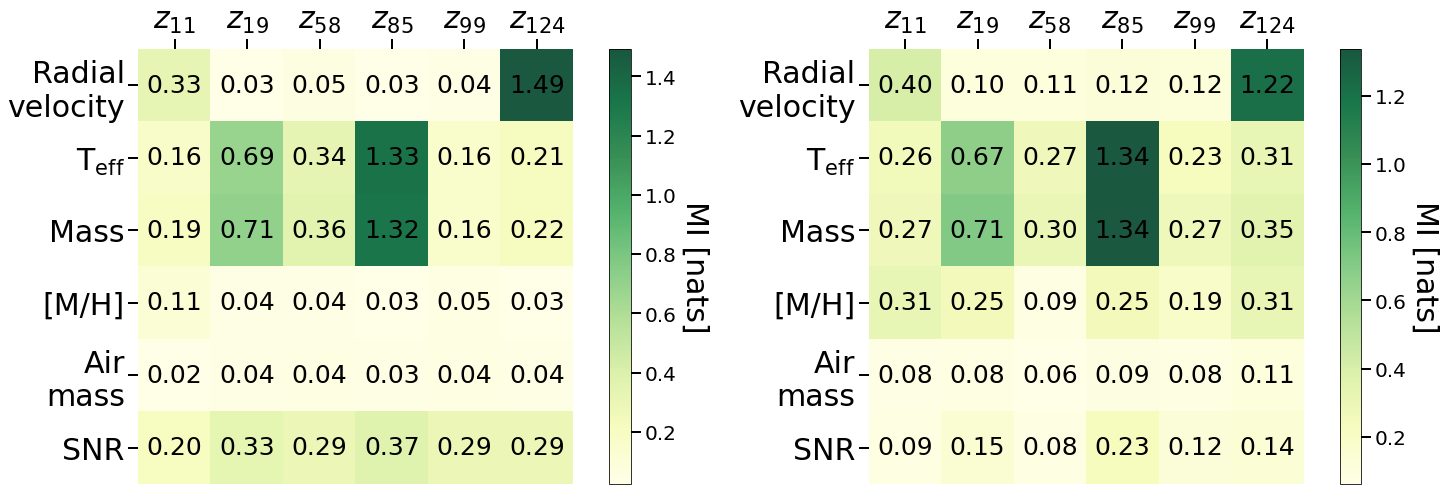

In [142]:
# plot

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.tick_params(labelsize=20, length=10, width=2) 
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=30)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(labels=col_labels, fontsize=30)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(labels=row_labels, fontsize=30)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, length=10, width=2)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #         rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, gmm_mi_std=None, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
        

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            #if data[i, j] == 0:
            #    continue
            #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

stellar_params_ = ['Radial\nvelocity','T$_{\mathregular{eff}}$','Mass','[M/H]','Air\nmass','SNR']#,'vsini']
vegetables = stellar_params_
farmers = [f"$z_{{{i}}}$" for i in indices_to_keep]#[f"$z_{i+$" for i in range(6)]

harvest = MI_values[:-1]


fig, (ax, ax1) = plt.subplots(1, 2, figsize=(24, 8))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)

harvest = sed_MI

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax1,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)
#fig.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('Sedaghat_MI.png', bbox_inches='tight')

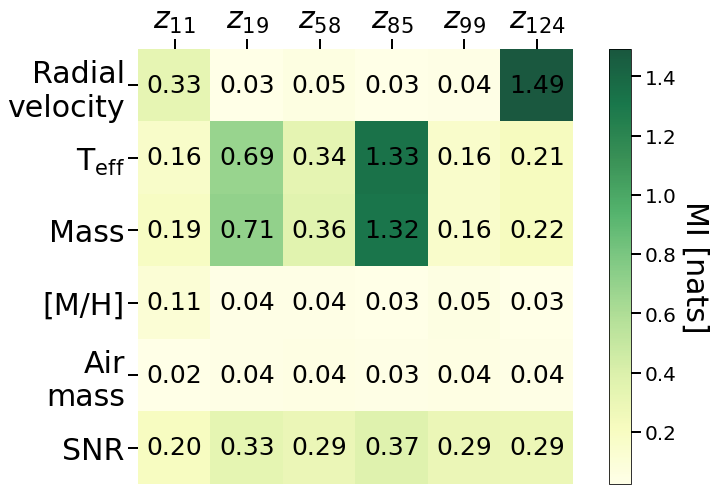

In [143]:
harvest = MI_values[:-1]

fig, (ax) = plt.subplots(1, 1, figsize=(24, 8))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)

plt.savefig('Sedaghat_MI_1.png', bbox_inches='tight')

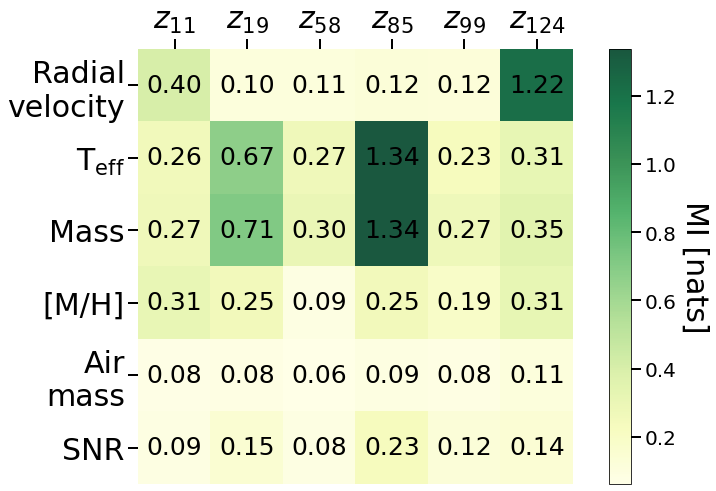

In [144]:
fig, (ax1) = plt.subplots(1, 1, figsize=(24, 8))


harvest = sed_MI

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax1,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)
#fig.tight_layout()
plt.savefig('Sedaghat_MI_2.png', bbox_inches='tight')